# Multi-Frame Motion Deblur Simulations
This notebook generates a simulation object, solves the linear inverse problem, and saves the dataset in the iotools.Dataset format.

In [47]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# General imports
import matplotlib.pyplot as plt

# Libwallerlab imports
import libwallerlab.projects.motiondeblur as md
from libwallerlab.projects.motiondeblur import blurkernel 
from libwallerlab.utilities import display, io, simulation

# Submodule imports
import ndoperators as ops
import llops as yp
from llops import Ft, iFt, astype, asbackend, ones, zeros, setByteOrder, changeBackend, reshape, vec
from ndoperators.solvers import objectivefunctions, regularizers

# Set default backend and dtype
yp.setDefaultBackend('numpy')
yp.setDefaultDatatype('float32')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Motion Blur Parameters

In [48]:
# Blur parameters
blur_axis = 1
blur_fov_fraction = 0.4
blur_illumination_fraction = 0.5
blur_type = 'pseudo-random'

# Crop parameters
image_count = 20
image_overlap = 0.2 # 20%

# Generate Object

## Load Object and Crop to Support

<IPython.core.display.Javascript object>


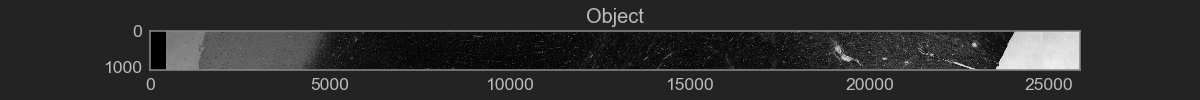

Text(0.5, 1.0, 'Object')

In [77]:
# Load object
object_true = simulation.brainstrip(absorption_max=1.5, absorption_min=0.5)

# Generate object size
object_size = yp.shape(object_true)

# Calculate Image Size
image_size = list(object_size)
image_size[blur_axis] = int(round(object_size[blur_axis] * (1 + image_overlap) / image_count))

# Show object and pupil
plt.figure(figsize = (12,1))
plt.imshow(yp.real(object_true), cmap='gray')
plt.title('Object')

# Create Blur Kernel

In [ ]:
k = md.blurkernel.gene

In [70]:
# Generate blur kernel
blur_kernel_length = int(round(image_size[blur_axis] * blur_fov_fraction))
if blur_type == 'constant':
    illum = yp.ones(blur_kernel_length) * blur_illumination_fraction
elif blur_type == 'pseudo-random':
    illum, _ = md.blurkernel.genRandInitialization(blur_kernel_length, blur_illumination_fraction)
elif blur_type == 'random':
    illum = np.random.uniform(size=blur_kernel_length)
    
# Expand illum to 2D and ensure it's in the correct direction
illum = yp.expandDims(illum, 2).T
illum /= yp.sum(illum)
    
# Generate blur kernels
blur_kernel_image = yp.pad(yp.expandDims(illum, 2).T, image_size, center=True)
blur_kernel_object = yp.pad(yp.expandDims(illum, 2).T, object_size, center=True)

# Blur Object

In [71]:
blurred_object = yp.fft.convolve(object_true, yp.expandDims(illum, 2))

# Segment Object into Images

In [73]:
image_step_in_blur_axis = image_size[blur_axis] * (1. - image_overlap)

measurement_roi_list = []
measurement_list = []
for image_index in range(image_count):
    # Calculate start position
    start = [0, 0]
    start[blur_axis] = image_index * image_step_in_blur_axis
    
    # Generate ROI and append to list
    measurement_roi_list.append(yp.Roi(start=start, shape=image_size, input_shape=object_size))
    
    measurement_list.append(blurred_object[measurement_roi_list[-1].slice])

<IPython.core.display.Javascript object>


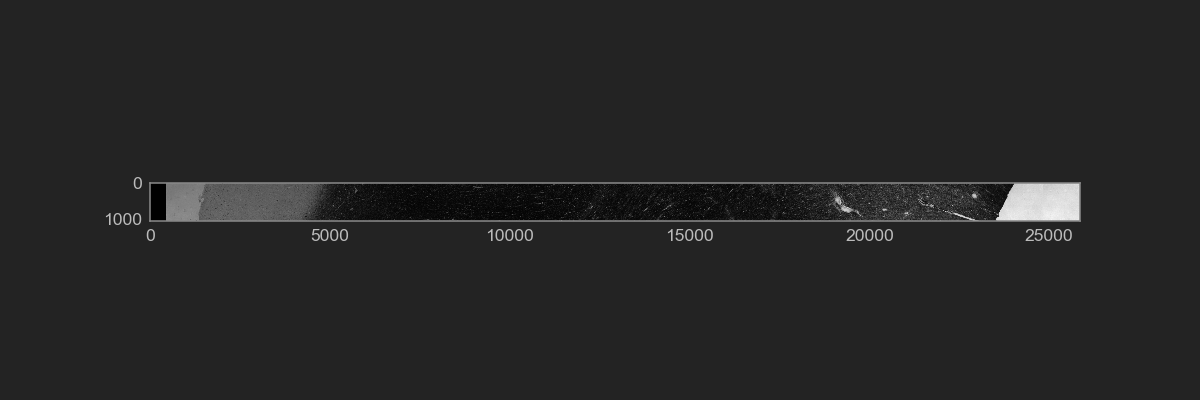

<IPython.core.display.Javascript object>


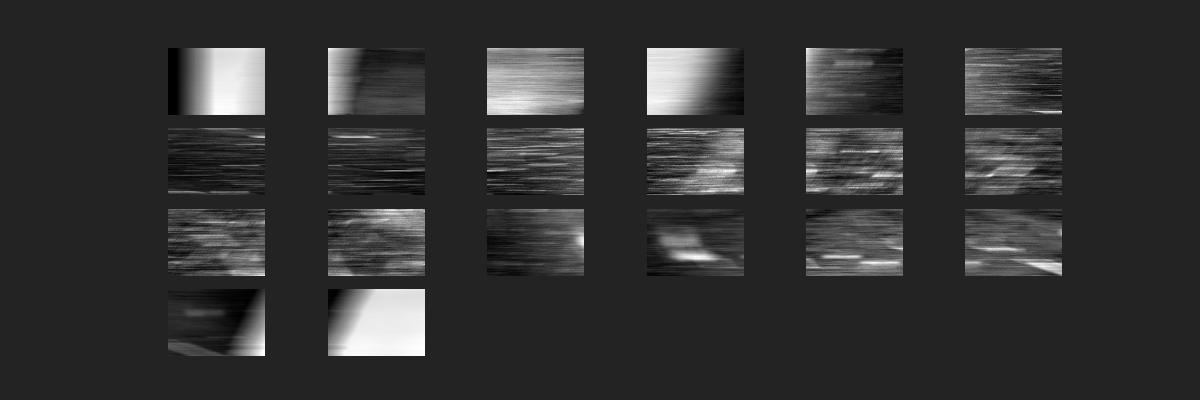

In [74]:
plt.figure()
plt.imshow(yp.real(object_true), cmap='gray')

yp.display.listPlotFlat(measurement_list)

<IPython.core.display.Javascript object>


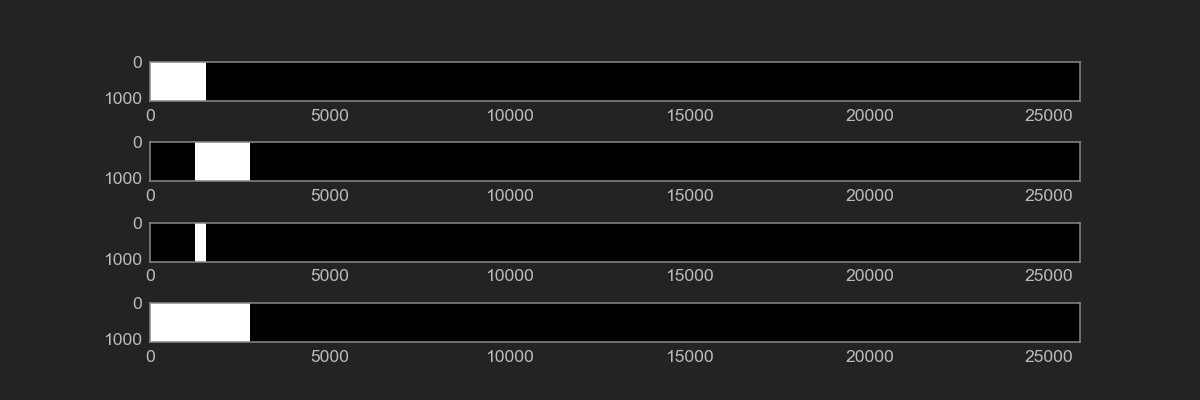

In [39]:
roi_prod = roi_0 * roi_1
roi_sum = roi_0 + roi_1
plt.figure()
plt.subplot(411)
plt.imshow(roi_0.mask)
plt.subplot(412)
plt.imshow(roi_1.mask)
plt.subplot(413)
plt.imshow(roi_prod.mask)
plt.subplot(414)
plt.imshow(roi_sum.mask)

# Format Data into Correct Format

In [78]:
data = []
for measurement_index in range(len(measurement_roi_list) - 1):

    roi_0 = measurement_roi_list[measurement_index]
    roi_1 = measurement_roi_list[measurement_index + 1]
    roi_total = roi_0 + roi_1

    # Generate ground truth image
    ground_truth = object_true[roi_total.slice]

    # Generate image pair
    measurements = (measurement_list[measurement_index], measurement_list[measurement_index + 1])
    
    # Append to data
    data.append({'ground_truth': ground_truth, 'measurements': measurements})

<IPython.core.display.Javascript object>


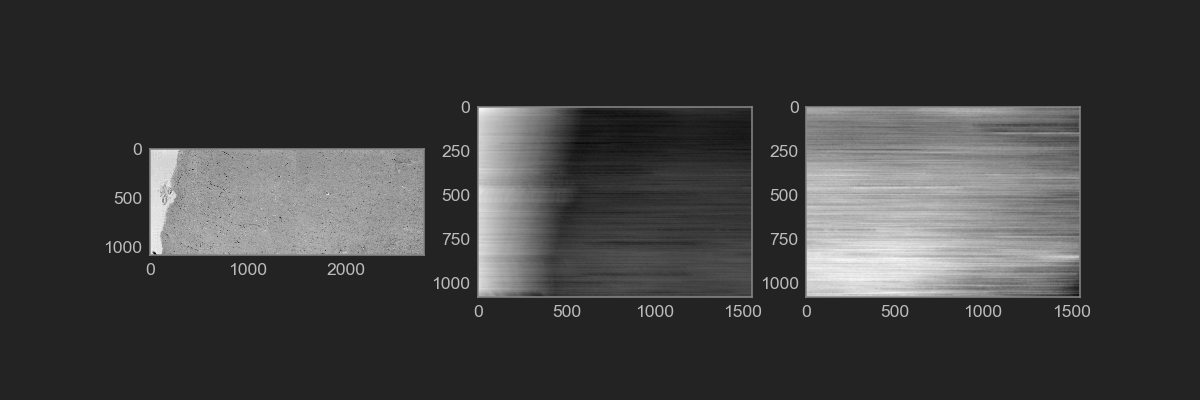

In [79]:
index = 1
plt.figure()
plt.subplot(131)
plt.imshow(yp.real(data[index]['ground_truth']))
plt.subplot(132)
plt.imshow(yp.real(data[index]['measurements'][0]))
plt.subplot(133)
plt.imshow(yp.real(data[index]['measurements'][1]))